# Quantum Machine Learning for Near-Earth Object Hazard Classification

## Project Overview

Near-Earth Objects (NEOs), such as asteroids and comets, represent a potential threat to Earth due to their proximity and, in rare cases, possible collision events. Although the probability of impact is low, the consequences can be severe, making the identification of hazardous objects an important scientific and technological challenge.

This project explores the use of Quantum Machine Learning (QML) techniques to perform binary classification of NEOs as *hazardous* or *non-hazardous*, based on observable and orbital characteristics provided by NASA’s NEO datasets. The problem is representative of high-dimensional, non-linear data commonly encountered in space science.

The main objective is to design, implement, and analyze a QML-based classifier, while critically assessing how different choices—such as feature selection, preprocessing strategies, quantum feature maps, and model architectures—affect performance. Whenever relevant, results are compared against classical machine learning baselines to contextualize the advantages and limitations of quantum approaches.


## Phase 1: Data Preprocessing and Feature Preparation

The performance of both classical and quantum machine learning models is highly dependent on the quality and structure of the input data. In quantum machine learning in particular, preprocessing plays a crucial role due to constraints on input dimensionality, circuit depth, and noise sensitivity.

This phase focuses on cleaning and preprocessing the Near-Earth Object dataset prior to model construction. Rather than treating preprocessing as a purely technical step, the goal is to develop an understanding of how data characteristics influence downstream learning, especially in the context of quantum models.

The preprocessing phase is structured into the following steps:

1. **Dataset inspection and understanding**  
   Identify feature types, the target label, missing values, and non-informative attributes.

2. **Handling missing values**  
   Decide whether to remove or impute features based on their relevance, missing value distribution, and potential impact on model bias.

3. **Feature selection and scaling**  
   Select physically and statistically meaningful features and apply appropriate scaling to ensure numerical stability and compatibility with quantum feature maps.


In [1]:
import pandas as pd

df = pd.read_csv("neo.csv")

print(df.shape)

# tipos de datos
print(df.dtypes)

# missing values por columna (top 20)
na = df.isna().sum().sort_values(ascending=False)

print(na)


(90836, 10)
id                      int64
name                   object
est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
orbiting_body          object
sentry_object            bool
absolute_magnitude    float64
hazardous                bool
dtype: object
id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64


In [2]:
# Check values of column orbiting_body
print(df['orbiting_body'].value_counts())

orbiting_body
Earth    90836
Name: count, dtype: int64


#### Analysis of Categorical Features

The dataset contains a single categorical feature, `orbiting_body`, indicating the celestial body around which the object orbits. An inspection of its unique values reveals that all samples correspond to objects orbiting Earth.

Since this feature exhibits no variability across the dataset, it does not provide any discriminative information for the classification task. Consequently, `orbiting_body` is treated as a constant feature and removed during preprocessing.


#### Removal of Non-Informative Features

Prior to model training, features were evaluated based on their relevance and potential contribution to the classification task.

The columns `id` and `name` serve exclusively as identifiers and do not encode physical or orbital properties of Near-Earth Objects. Including such identifiers would risk memorization rather than generalizable learning and was therefore avoided.

These features were excluded from the dataset before further analysis and model development.


In [3]:
df = df.drop(columns=["id", "name", "orbiting_body"])

In [4]:
df.describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


The descriptive statistics indicate that all numerical features lie within physically plausible ranges. No invalid values such as negative distances or velocities were observed. Several features, particularly estimated diameters and miss distance, span multiple orders of magnitude, reflecting the natural variability of Near-Earth Objects rather than data quality issues.


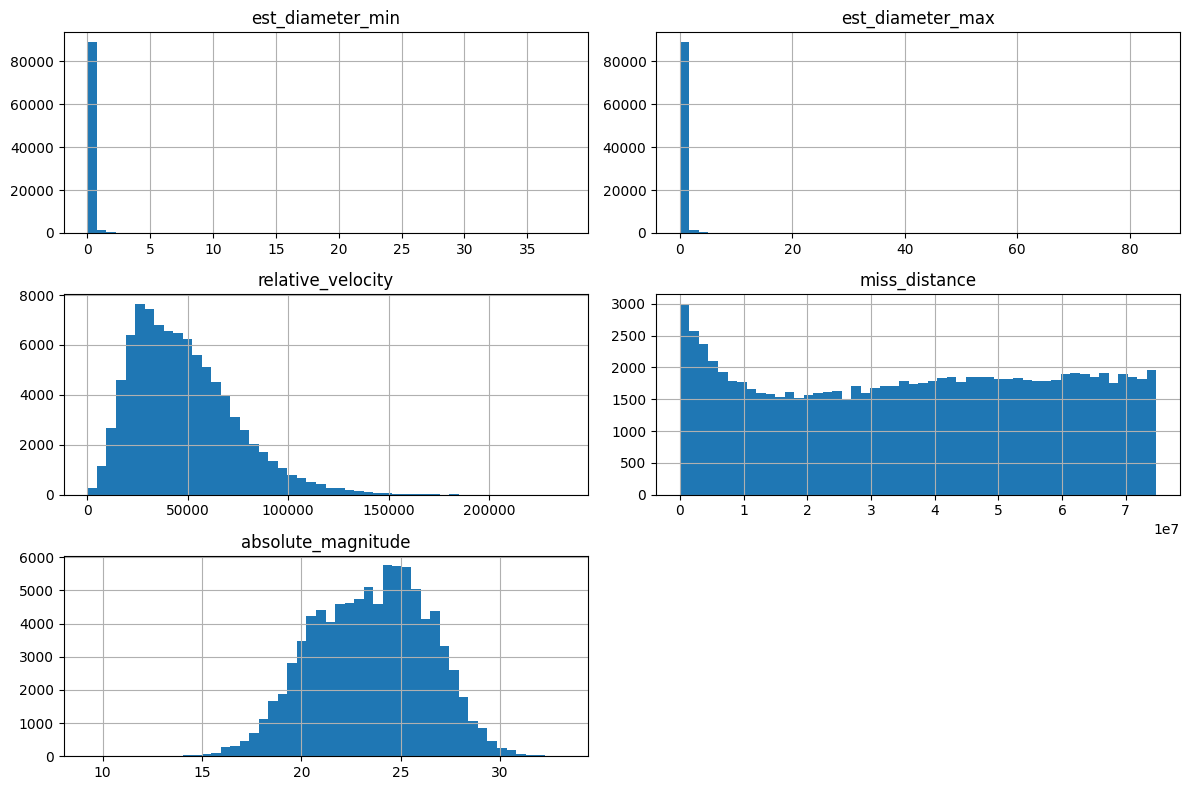

In [5]:
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(12,8))
plt.tight_layout()


Histogram analysis reveals that most physical features exhibit skewed distributions with long tails, which is characteristic of astrophysical data. In contrast, absolute magnitude follows a more symmetric distribution. These observations motivate the use of feature scaling prior to model training, particularly for quantum machine learning models where input normalization is critical.


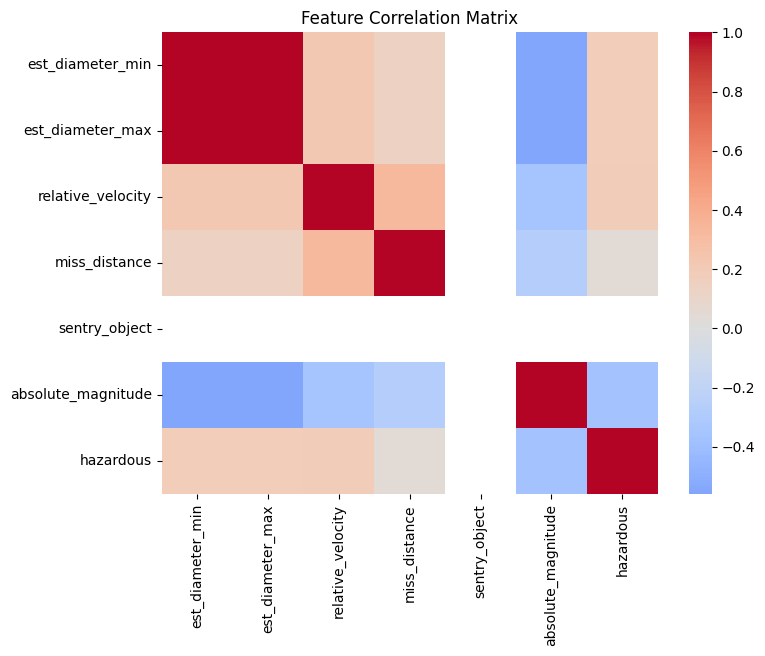

In [6]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()


The correlation matrix reveals strong redundancy between `est_diameter_min` and `est_diameter_max`, which is expected given their physical definition. This redundancy is particularly relevant in a quantum setting, where minimizing input dimensionality directly reduces circuit complexity.


In [7]:
df.corr()["hazardous"].sort_values(ascending=False)


hazardous             1.000000
relative_velocity     0.191185
est_diameter_max      0.183363
est_diameter_min      0.183363
miss_distance         0.042302
absolute_magnitude   -0.365267
sentry_object              NaN
Name: hazardous, dtype: float64

In [8]:
#Check values for sentry_object
print(df['sentry_object'].value_counts())

sentry_object
False    90836
Name: count, dtype: int64


Correlation analysis with the target label shows that no single feature exhibits a strong linear relationship with hazard classification, highlighting the non-linear nature of the problem. Notably, absolute magnitude shows the strongest association, consistent with known physical interpretations. The `sentry_object` feature yields undefined correlation, we can confirm this is beacuse the whole dataset has a constant False value.


#### Final Feature Selection

Based on the exploratory analysis, a final subset of features was selected to balance physical relevance, statistical informativeness, and model efficiency. The features `id`, `name`, and `orbiting_body` were removed due to their non-informative nature, while `sentry_object` was excluded due to its lack of variability and potential risk of target leakage.

The estimated diameter features exhibited near-perfect correlation. To reduce redundancy and limit input dimensionality only `est_diameter_max` was retained as a conservative representation of object size.

The final feature set consists of:
- Estimated maximum diameter
- Relative velocity
- Miss distance
- Absolute magnitude

This selection preserves meaningful physical information while minimizing unnecessary complexity.


In [9]:
df = df.drop(columns=["est_diameter_min", "sentry_object"])

In [ ]:
# Check final columns
print(df.columns)

Index(['est_diameter_max', 'relative_velocity', 'miss_distance',
       'absolute_magnitude', 'hazardous'],
      dtype='object')


In [12]:
X = df.drop(columns=["hazardous"])
y = df["hazardous"]

In [13]:
from sklearn.model_selection import train_test_split

# Separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

# Separate validation and training sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.176,  
    random_state=42,
    stratify=y_train_val
)


To ensure a fair evaluation of model performance, the dataset was split into training, validation, and test subsets. Stratified sampling was applied to preserve the class distribution across all splits. Feature scaling and any data-dependent transformations were deferred until after the split to prevent data leakage.


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


#### Feature Scaling and Data Splitting

After selecting the final feature set, the data was divided into training, validation, and test subsets using stratified sampling. Feature scaling was performed using standardization to ensure numerical stability and compatibility with quantum feature maps.

Importantly, the scaler was fitted exclusively on the training data and subsequently applied to the validation and test sets. This procedure prevents information leakage and ensures that performance metrics reflect true generalization.
